<a href="https://colab.research.google.com/github/urstkk/Adverse_reaction_using_FDA_API/blob/main/OpenFDA%20API%20for%20FAERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAERS Adverse Reaction Events database and OpenFDA API


    Author: Krishna Kishore
    Date: Dec. 2021


Adverse reaction event is reported to the FDA via Adverse Event Reporting System. Each report contains general information about the report, patient information, a list of the drugs that the patient is taking, and a list of the patient reactions.

**Drug** in this database could be a medicine, a biologic product or other nonmedicinal consumer product.

**Adverse reaction event** is any undesirable experience associated with the use of a medical product in a patient. Below we will also be using an abbreviation ADR: adverse drug reaction.

**Pharmacovigilance**: FAERS provides a way for medical professionals and consumers to notify about adverse reaction events. Ultimately, this information should be used to improve drug safety. However, there are multiple limitations, discussed further, that should also be considered.


## About the database

FAERS reports are aggregated quarterly and available directly as tabular database dumps or XML via https://fis.fda.gov/extensions/FPD-QDE-FAERS/FPD-QDE-FAERS.html 

OpenFDA consumes the FAERS data and applies several preprocessing procedures, including harmonization of various identifiers and adding metadata to drug entities. 

OpenFDA is an open access database built on top of ElasticSearch engine. It can be queried via a web API in JSON format or as a downloadable archive corresponding to the /drug/event/ API endpoint (https://open.fda.gov/apis/drug/event/). Data files are split into chunks up to 150MB, with up to 2GB files per year quarter. Currently thre are circa 1000 files overall.

Importing FAERS data may be a more efficient way (60 MB archived CSV quarterly), however it lacks harmonization that OpenFDA API provides.


## Known limitations

One of the major limitations of the database is that the data is not curated or filtered in any way. The FDA is clear about it. Even the API response headers mention that the data has not been validated by FDA.

Below are four quotations from the OpenFDA documentation that emphasize on the limitations:

    “When a report lists multiple drugs and multiple reactions, there is no way to conclude from the data therein that a given drug is responsible for a given reaction.”

    “Any number of the drugs may be marked as suspect if thought to be responsible for one or more of the reactions, but that information is not validated. Concomitant drugs are those which are not suspected of causing one or more of the reactions. Many drug products appear frequently in adverse event reports simply because they are commonly taken by many people in the population, not because they are responsible for more adverse events.“

    “Adverse event reports submitted to FDA do not undergo extensive validation or verification. Therefore, a causal relationship cannot be established between product and reactions listed in a report. While a suspected relationship may exist, it is not medically validated and should not be the sole source of information for clinical decision making or other assumptions about the safety or efficacy of a product.”

    “FDA does not receive reports for every adverse event or medication error that occurs with a product”


Summary of the limitations of FAERS:

1.  The FAERS data by themselves are not an indicator of the safety profile of the drug or biologic
2.	Duplicate and incomplete reports are present in the system
3.	Existence of a report does not establish causation
4.	Information in reports has not been verified or validated
5.	Rates of occurrence cannot be established with reports
6.  The database is not free from various reporting biases

Technical limitations of the database and the API:

1. Any update to the data could change old records
2. Data only covers period since 2004
3. The data is updated quarterly and there may be a 3 month lag
4. The rate of OpenFDA API queries is limited


## Outline and scope of the report

The scope of this exploratory analysis would be to use *count* and *search* OpenFDA API queries to retrive summary statistics and subsets of data. While examining and visualizing the overall structure of OpenFDA data, we can formulate a number of exploratory questions and attempt to answer these questions with the data.

This report has the following outline:
	1. Accessing the data and the underlying data structures
    2. Examining the size and growth trends of the database
    3. Examining the presence of reporting biases in the data: age, sex, reporter
    4. How drugs are defined and what are the commonly reported drugs?
    5. What are the most common drug indications?
    6. How are adverse reactions defined and what are the most common ones?
    7. How serious are adverse reactions reported
    8. Are there any reporting biases or trends depending on the reaction?
    9. Do we have any more confidence in some ADR reports than the others?
    10. More specifically, how can we infer causality of drug-ADR relationship?
    11. Apply measures of disproportionality in ADR reports to analyze drug-ADR relationships
    12. Find drugs with similar adverse reactions within the same drug indication area (drug-drug relationships)
    13. Suggesteed possible future directions

On a technical note, the analysis is implemented in a Jupyter notebook in Python 3.6+. Description of the environment and package dependencies are provided in *environment.yml* file on github. Github page also provides links to Binder2 an Google Collab clouds, where an image with all the requirements in place could be instantiated. Running the notebook requires internet connection to access the web API.


## Accessing the data

There are multiple ways the data could be accessed:

1. Database dumps downloaded from FAERS
2. JSON snapshots downloaded from OpenFDA
3. Subsets of data downloaded from OpenFDA via the API
4. OpenFDA API queried via web
5. OpenFDA API via a higher-level ElasticSearch API, such as elasticsearch-dsl for Python

The preferred way that would provide most flexibility for the downstream analysis is downloading the harmonized database from OpenFDA and improrting it into Apache Spark or relational database. However, the scope of this report is to explore the OpenFDA web API, thus in this report we will be relying upon access methods 3 and 4.

The format of the results returned by the web API is described in a YAML document, which also contains explanation of fields and numeric values.

Harmonization of OpenFDA provides a valuable outcome that the terms are consistent with the corresponding ontologies. For instance, reactions are consistent with medDrap dictionary.

OpenFDA API is rate-limited with 40 requests per minute without an API key. We need to respect such limits and implement throttling in case of sequential requests. Throttling is implemented via *ratelimit* package.

In order to minimize the burden on the API we also need to implement caching of repetitive requests. Caching to a local sqlite database file is implemented via *requests_cache* package.

The API returns numeric identifiers, which are impossible to interpret without the metadata. Below, we will often merge API calls with metadata lookups in order to assign text values to numeric identifiers.

In [1]:
import pandas as pd
from pprint import pprint

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (4, 3)

In [3]:
import requests

# rate limiting is important to avoid accidental service abuse of the OpenFDA API provider
!pip install ratelimit
!pip install requests_cache
!pip install munch
!pip install PyYAML==5.1
from ratelimit import limits, sleep_and_retry


# cache API calls in a sqllite file to reduce the number of requests to openfda server
import requests_cache
requests_cache.install_cache('openfda_cache')

OPENFDA_API = "https://api.fda.gov/drug/event.json"

@sleep_and_retry
@limits(calls=40, period=60)
def call_api(params):
    """
    OpenFDA API call. Respects rate limit. Overrides default data limit
    Input: dictionary with API parameters {search: '...', count: '...'}
    Output: nested dictionary representation of the JSON results section
    
    OpenFDA API rate limits:
         With no API key: 40 requests per minute, per IP address. 1000 requests per day, per IP address.
         With an API key: 240 requests per minute, per key. 120000 requests per day, per key.
    """
    if not params:
        params = {}
    params['limit'] = params.get('limit', 1000)
    response = requests.get(OPENFDA_API, params=params)
    # print(response.url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response.json()['results']


OPENFDA_METADATA_YAML = "https://open.fda.gov/fields/drugevent.yaml"
# munch is a yaml parser with javascript-style object access
from munch import Munch

def api_meta():
    """
    YAML file with field description and other metadata retrieved from the OpenFDA website
    Parses YAML file and provides syntactic sugar for accessing nested dictionaries
    Example: .patient.properties.patientagegroup.possible_values.value
    Note: reserved words, such as count and items still have to be accessed via ['count'], ['items']
    """
    response = requests.get(OPENFDA_METADATA_YAML)
    if response.status_code != 200:
        raise Exception('Could not retrieve YAML file with drug event API fields')
    y = Munch.fromYAML(response.text)
    return y['properties']
    

call_api() and api_meta() restuls could be merged when text annotation of values is needed

## Exploring the event report structure

We use YAML metadata to examine the data structure.

Adverse event report has a hierarchical structure with metadata on the top level. *Patient* substructure contains the key pieces of information: *drug* and *reaction*

In [4]:
!pip uninstall PyYAML==5.1
!pip install PyYAML==5.1
import yaml
api_meta().patient.properties.keys()

Found existing installation: PyYAML 5.1
Uninstalling PyYAML-5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PyYAML-5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/yaml/*
Proceed (y/n)? y
  Successfully uninstalled PyYAML-5.1
  Using cached PyYAML-5.1-cp37-cp37m-linux_x86_64.whl


dict_keys(['drug', 'patientagegroup', 'patientdeath', 'patientonsetage', 'patientonsetageunit', 'patientsex', 'patientweight', 'reaction', 'summary'])

*Drug* entry is an array of records. Each record has redundant (denormalized) information about the drug, its packaging, indication and the way of administration. It also contains unique identifiers (not the *openfda* substructure).

There is no direct indication of association between drug and reaction.

In [5]:
api_meta().patient.properties.drug['items'].properties.keys()

dict_keys(['actiondrug', 'activesubstance', 'drugadditional', 'drugadministrationroute', 'drugauthorizationnumb', 'drugbatchnumb', 'drugcharacterization', 'drugcumulativedosagenumb', 'drugcumulativedosageunit', 'drugdosageform', 'drugdosagetext', 'drugenddate', 'drugenddateformat', 'drugindication', 'drugintervaldosagedefinition', 'drugintervaldosageunitnumb', 'drugrecurreadministration', 'drugrecurrence', 'drugseparatedosagenumb', 'drugstartdate', 'drugstartdateformat', 'drugstructuredosagenumb', 'drugstructuredosageunit', 'drugtreatmentduration', 'drugtreatmentdurationunit', 'medicinalproduct', 'openfda'])

*Reaction* description uses MedDrapt dictionary and the action which was taken as an outcome.

In [6]:
api_meta().patient.properties.reaction['items'].properties.keys()

dict_keys(['reactionmeddrapt', 'reactionmeddraversionpt', 'reactionoutcome'])

## FAERS database size and growth trends

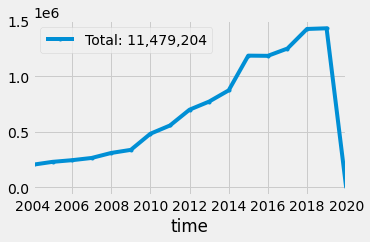

In [7]:
df = pd.DataFrame(
    call_api({
        'count':'receivedate',
        'search': 'receivedate:[20040101 TO 20200101]'}))
df.index = pd.to_datetime(df.time)
# tally reports by year
df.drop('time', axis=1).resample("y").sum().plot(style='.-', figsize=(5, 3))
total = df['count'].sum()
plt.gca().legend(["Total: {:,}".format(total)])
plt.show()

Overall, there are 11M+ reports in the database since 2004. The plot shows increasing growth in the number of reports over the years, approaching 1.5M reports a year currently. Data for 2019 is partially incomplete.

## Examining age and sex biases

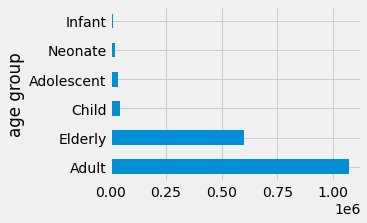

In [20]:
df = pd.DataFrame(
    call_api({
        "count": "patient.patientagegroup"}))
meta = pd.Series(
            api_meta().patient.properties.patientagegroup.possible_values.value
       ).to_frame('age group')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('age group', 'count')
plt.gca().get_legend().remove()

Age biases need to be taken into account because some adverse reactions could be linked to age-related differences in physiology. I.e. age could be a confounding factor for the downstream analysis.

There is limited information about adverse reactions in children.

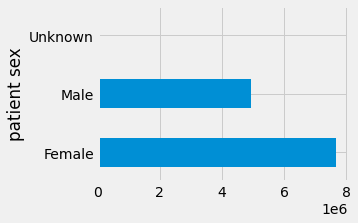

In [21]:
df = pd.DataFrame(
    call_api({
        "count": "patient.patientsex"}))
meta = pd.Series(
            api_meta().patient.properties.patientsex.possible_values.value
       ).to_frame('patient sex')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('patient sex', 'count')
plt.gca().get_legend().remove()

Approximately 60% of reports are for females and 40% are for males. Sex could be an important confounding factor as well and a reporting bias may skew the results or limit our ability to generalize findings.

## Who submits reports to the database?

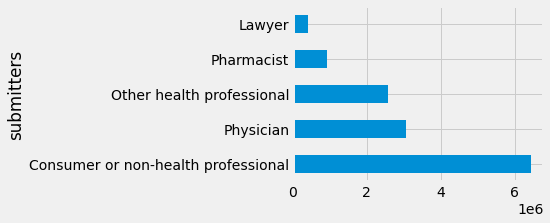

In [22]:
df = pd.DataFrame(
    call_api({"count": "primarysource.qualification"}))
meta = pd.Series(
            api_meta().primarysource.properties.qualification.possible_values.value
       ).to_frame('submitters')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('submitters', 'count')
plt.gca().get_legend().remove()
plt.show()

## Drugs

A list of drugs is provided with each ADR report. Drugs have a wealth of annotation in different ontologies:

- drug.openfda.rxcui 

- NDA identifier label

- patient.drug.openfda.pharm_class_epc (pharmacologic class)

- patient.drug.activesubstance

There are different manufacturers, drug forms, dosages and administration methods that we will disregard in this simplified approach. For the purpose of this analysis we will be relying on activesubstance. DrugBank also uses activesubstance as a generalization of drug entity definition.

In some cases there are a few entries in one activesubstance field separated by slash. Where appropriate, only the firsst entry will be considered.

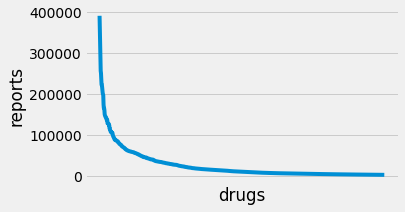

In [23]:
df = pd.DataFrame(call_api({"count": "patient.drug.activesubstance.activesubstancename.exact"}))
df.plot.line('term', 'count', figsize=(5,3))
plt.xlabel("drugs")
plt.ylabel("reports")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().get_legend().remove()
plt.show()

This plot shows the distribution of reports mentioning the drug for the top 1000 drugs. Note that the relationship is exponential - a relatively small number of drugs are mentioned in the majority of reports.

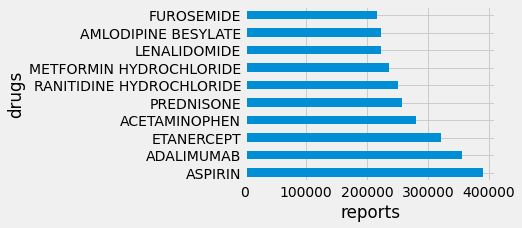

In [24]:
df[0:10].plot.barh('term', 'count')
plt.ylabel("drugs")
plt.xlabel("reports")
plt.gca().get_legend().remove()

We can visualize the list of top 10 drugs by mentions, where aspirin is the most reported one.

However if we would like to see more than 50 top drugs it will be difficult to show on one plot.

Word cloud is an intuitive way of visualizing word term frequencies. The plot below gives us an overview of th most common drugs in the database.

In [25]:
from wordcloud import WordCloud

def show_wordcloud(words, background="black", color="viridis"):
    """Generate word cloud image from a dictionary of word frequencies"""
    
    # generate word cloud
    wc = WordCloud(
        background_color=background,
        max_words=50,
        max_font_size=30,
        colormap=color)
    
    image = wc.generate_from_frequencies(words)
    
    # show
    plt.figure(figsize=(10,6))
    plt.imshow(image, interpolation="bilinear")
    plt.axis("off")
    plt.show()

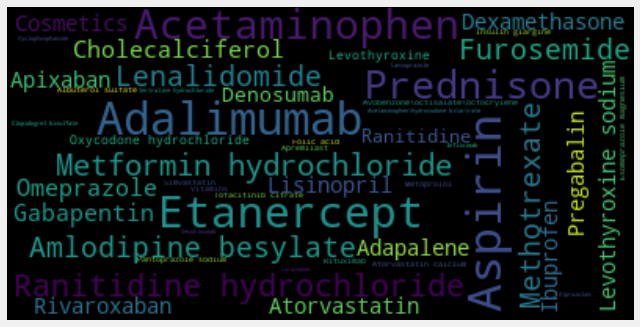

In [26]:
counts = call_api({
    "count": "patient.drug.activesubstance.activesubstancename.exact"})
words = { d['term'].capitalize(): d['count'] for d in counts }
show_wordcloud(words)

Note that in principle we could use color to encode some additional information, such as drug class.

## Drug indications

Drug indications allow to look at conditions being treated. It may be important to stratify reports by a condition before looking for overrepresentation of a particular adverse reaction in association with a drug.

Limitations: Not every drug has indications specified.

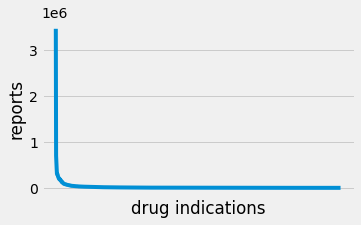

In [27]:
df = pd.DataFrame(call_api({"count": "patient.drug.drugindication.exact"}))
df.plot.line('term', 'count', figsize=(5,3))
plt.xlabel("drug indications")
plt.ylabel("reports")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().get_legend().remove()
plt.show()

Not surprisingly, for some conditions are most commonly mentioned. Visually, the exponential decay is even sharper than with the drugs, meaning that we have more indications with a relatively few ADR reported.
The plot above shows top 1000 drug indications.

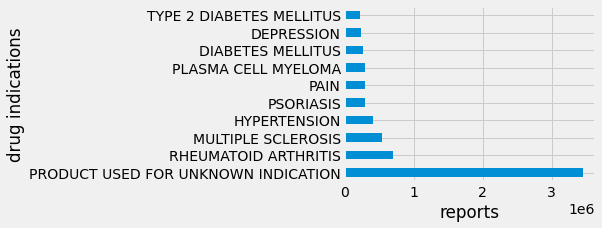

In [28]:
df[0:10].plot.barh('term', 'count')
plt.ylabel("drug indications")
plt.xlabel("reports")
plt.gca().get_legend().remove()

In the top10 list we have two entries where product or drug used for unknown indications.
Perhaps these cases could be combined with those for which there is no data on indication specified at all (N/A).

An anecdotal note, it appears that the indications in top10 list require complex multi-drug therapies.

For consistency of visualization we will also show a word cloud for drug indications below, excluding the top1 (product used for unknown indication)

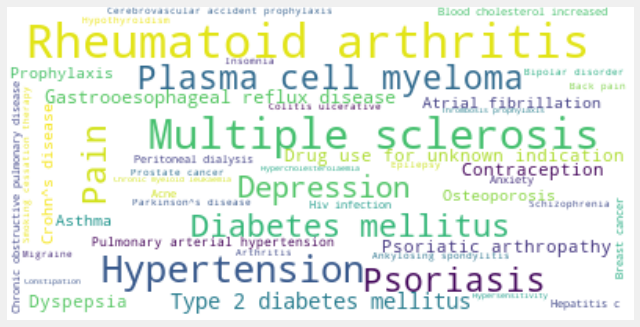

In [29]:
from itertools import islice

counts = call_api({
    "count": "patient.drug.drugindication.exact"})
words = { d['term'].capitalize(): d['count'] for d in islice(counts, 1, None) }
show_wordcloud(words, background="white")

It is important to emphasize again that there are no data provided to link drugs or drug indications to adverse reactions directly.

# Adverse reactions

Adverse reactions is the core concept of this database. It is based on terms defined in MedDrapt dictionary.

Adverse reactions follow the same exponential decay pattern as drugs or drug indications, meaning that there are relatively few common reactions and a long tail of reactions which have been reported less often.

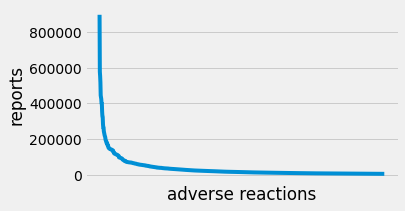

In [30]:
counts = call_api({
    "count": "patient.reaction.reactionmeddrapt.exact"})
df = pd.DataFrame(counts)

df.plot.line('term', 'count', figsize=(5,3))
plt.xlabel("adverse reactions")
plt.ylabel("reports")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().get_legend().remove()
plt.show()

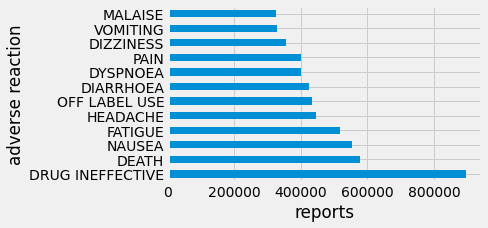

In [31]:
df[0:12].plot.barh('term', 'count', figsize=(5, 3))
plt.gca().get_legend().remove()
plt.xlabel("reports")
plt.ylabel("adverse reaction")
plt.show()

Top 12 list of reactions mention a number of conditions and cases.
Ineffective drug and Off label use are rather separate categories.
Death could be considered a separate category, because it is not clear what was the cause of death. For instance, if a drug was used to resuscitate, but failed to.

As with drugs and drug indications we will visualize top 50 most common adverse effects in a word cloud below.

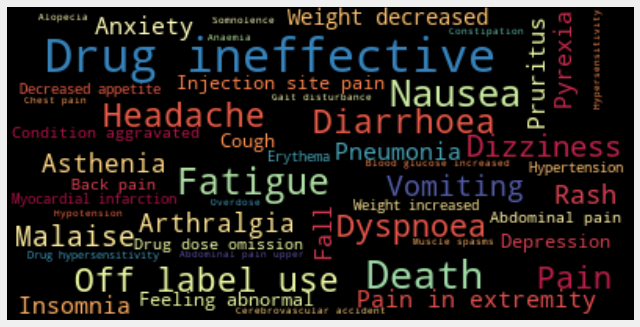

In [32]:
words = { d['term'].capitalize(): d['count'] for d in counts }
show_wordcloud(words, background="black", color="Spectral")

### Number of adverse reactions reported per event

The limitation of the ElasticSearch API is that it does not allow analytics other than counting reports with only one variable to group by. This means that we can not retrieve the number of adverse reactions per report directly with the available API, unless we query the API iteratively for every possible adverse reaction.
The data has to be loaded into Spark, or relational database, i.e. a backend that supports more complex queries.

## Temporal trends in reported adverse reactions (reporting biases)

There may be reporting biases in the database related to the changes in medical codes or other regulatory reasons or as an affect of media coverage of certain specific adverse reaction terms.

The function below returns a data deposition trend for a specific ADR. We can use the function to check individual trends.

In [33]:
def get_trend_for_reaction(reaction):
    """Returns dataframe with yearly tally of event reports for a given reaction"""
    df = pd.DataFrame(
        call_api({
            'count':'receivedate',
            'search': "receivedate:[20040101 TO 20200101] AND patient.reaction.reactionmeddrapt.exact: {}".format(
                reaction.upper()
            )}))
    df.index = pd.to_datetime(df.time)
    df = df.drop('time', axis=1).resample("y").sum().rename(
        columns={"count": reaction.capitalize()})
    return df

I am illustrating it with an example comparing Death, Pain and Syspnoea.
Visually, there is a reporting bias for Death vs Pain and Dispnoea. However, such analysis is inconclusive and may only indicate the need to consider additional normalization, particularly when building models on past data and applying the models to recent data snapshots.

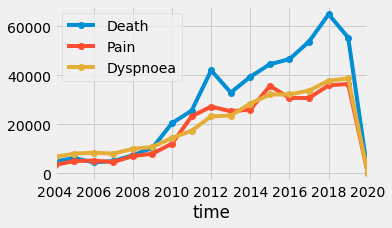

In [34]:
reactions = ['death', 'pain', 'dyspnoea']
df = pd.concat([get_trend_for_reaction(x) for x in reactions], axis=1)
df.plot(style='o-', figsize=(5, 3))
plt.show()

## Seriousness / Severity of adverse reactions

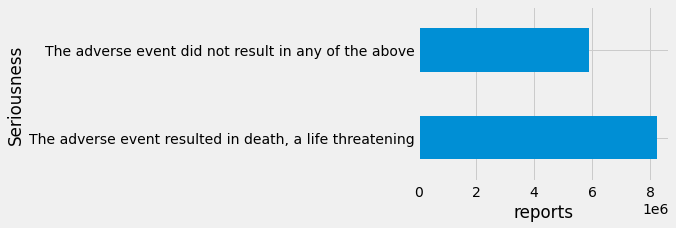

In [36]:
df = pd.DataFrame(call_api({"count": "serious"}))
meta = pd.Series(
            api_meta().serious.possible_values.value
       ).to_frame('Seriousness')
meta['term'] = meta.index.astype(int)
meta['Seriousness'] = list(map(lambda x: x[0:55], meta['Seriousness']))

df.merge(meta, on='term').plot.barh('Seriousness', 'count')
plt.xlabel("reports")
plt.gca().get_legend().remove()
plt.show()

Most of the reports indicate that at least on of the reaction is serious: life threatening or leading to disability.

It is important for comparison with other resources. 

For instance, DrugBank has no severity information, while all cases in ONCHigh are severe.

## Adverse reaction event validation

There are numerous precautions about the limitation in interpretability of the reports in terms of the causality of drug-ADR relationship.

It is important to find out whether some reports have more confidence/trust than the others.

Below we compare the sources of the reports. Whether they come from a designed clinical study or are spontaneous.

For instance, in order to apply certain statistical methods (as described further below) we may be restricted to using only spontaneous reports.

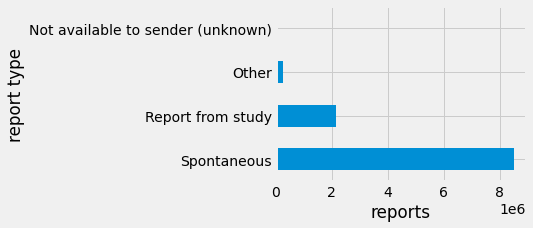

In [37]:
df = pd.DataFrame(call_api({"count": "reporttype"}))
meta = pd.Series(
            api_meta().reporttype.possible_values.value
       ).to_frame('report type')
meta['term'] = meta.index.astype(int)
df.merge(meta, on='term').plot.barh('report type', 'count')
plt.xlabel("reports")
plt.gca().get_legend().remove()
plt.show()

There is a field with an indication that drug may be suspected as causing the adverse reaction, or that the drug is only being taken along with the suspect drug.

Let us examine how many of these cases we have and then explore whether we can establish any more confidence using this preliminary indication that the drug may be the suspect.

In [38]:
api_meta().patient.properties.drug['items'].properties.drugcharacterization.description

'Reported role of the drug in the adverse event report. These values are not validated by FDA.'

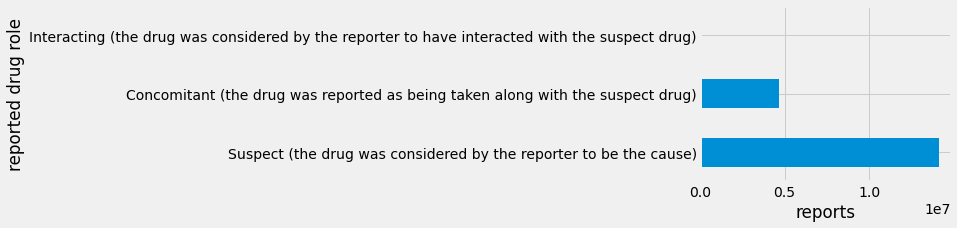

In [39]:
df = pd.DataFrame(call_api({
    "count": "patient.drug.drugcharacterization",
    }))

meta = pd.Series(
            api_meta().patient.properties.drug['items'].properties.drugcharacterization.possible_values.value
       ).to_frame('reported drug role')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('reported drug role', 'count')
plt.xlabel("reports")
plt.gca().get_legend().remove()
plt.show()

It may be more informative to look at this statistics per report, because there are multiple drugs per report.
However, this preliminary summary indicates that a large number of drugs are annotated as potential suspect.


One way of **validating adverse drug reaction** is dechallenge-rechallenge protocol:

1. There is an adverse reaction while taking the drug
2. Dechallenge: withdraw the drug or reduce the dose and check whether the ADR is abated
3. Rechallenge: administer the drug again and check whether the ADR reappears

This may not be a common protocol out of the clinical study setting. However, we can examine the database and check how many cases where dechallenge and/or rechallenge have been performed exist.

### Dechallenge outcome

In [40]:
api_meta().patient.properties.drug['items'].properties.drugadditional.description

'Dechallenge outcome information—whether the event abated after product use stopped or the dose was reduced. Only present when this was attempted and the data was provided.'

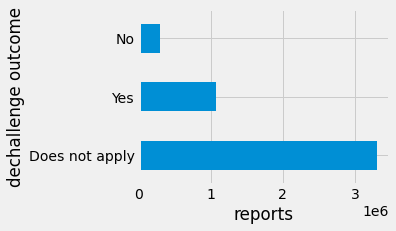

In [41]:
df = pd.DataFrame(call_api({
    "count": "patient.drug.drugadditional",
    }))
# 'search': "patient.drug.drugindication.exact: HYPERTENSION"

meta = pd.Series(
            api_meta().patient.properties.drug['items'].properties.drugadditional.possible_values.value
       ).to_frame('dechallenge outcome')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('dechallenge outcome', 'count')
plt.gca().get_legend().remove()
plt.xlabel("reports")
plt.show()

We have a large number of reports (c.a. 1M) where dechallenge has been attempted. These cases could be used to learn more about the drug-ADR relationships.

It is not clear how to interpret Does Not Apply outcome, it probably means missing data.

### Rechallenge outcome

In [42]:
api_meta().patient.properties.drug['items'].properties.drugrecurreadministration.description

'Whether the reaction occured after readministration of the drug.'

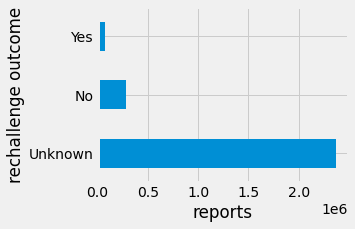

In [43]:
df = pd.DataFrame(call_api({
    "count": "patient.drug.drugrecurreadministration",
    }))
# 'search': "patient.drug.drugindication.exact: HYPERTENSION"

meta = pd.Series(
            api_meta().patient.properties.drug['items'].properties.drugrecurreadministration.possible_values.value
       ).to_frame('rechallenge outcome')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('rechallenge outcome', 'count')
plt.gca().get_legend().remove()
plt.xlabel("reports")
plt.show()

Rechallenge is much more dangerous, particularly in case of severe reactions. That is why it is not performed often. However, we may have a substantial number of cases where rechallenge has been performed (c.a. 300K reports). 

Again, it is not clear how to interpret Unknown outcome and whether it means missing data.

### Probability tables: joint, conditional, and marginal

There are several variables with different outcomes:

- drugcharacterization: Suspect or Concomitant

- drugadditional:  - dechallenge Yes / No

- drugrecurreadministration: - rechallenge Yes / No

These variables are not independent, however the nature of relationships between them may have to be established. In particular we would like to increase our confidence in that the drug is a suspect for a given ADR. Can the existing information about dechalllenge / rechallenge be used to assess the drug-ADR relationship?
To what extent the probability of drug being suspect increases when we know the result of dechallenge/rechallenge? Does the knowledge of dechallenge/rechallenge outcome indroduce conditional independence from drugcharacterization (Suspect or Concomitant)?

In order to attempt to answer these questions we need to build probabilistic graphical models.
Below, we will collect the report counts for each combination of outcomes into a joint probability table.

In [44]:
from itertools import product

df_all = pd.DataFrame()
for drugcharacterization, drugadditional in product((1,2,3), (1,2,3)):
    df = pd.DataFrame(call_api({
        "count": "patient.drug.drugrecurreadministration",
        'search': "patient.drug.drugcharacterization: {} AND patient.drug.drugadditional: {}".format(
        drugcharacterization, drugadditional)
    }))
    df['drugcharacterization'] = drugcharacterization
    df['drugadditional'] = drugadditional
    df = df.rename(columns={'term': 'drugrecurreadministration'})
    df_all = pd.concat([df_all, df])

df_all = df_all.reset_index(drop=True)

In [45]:
# df_all['prob'] = df_all.groupby(
#         ["drugcharacterization", "drugadditional"]
#     )['count'].transform(
#         lambda x: x / x.sum())
# df_all

df_all['joint_prob'] = df_all['count'] / df_all['count'].sum()
df_all.head()

,drugrecurreadministration,count,drugcharacterization,drugadditional,joint_prob
0,3,239980,1,1,0.116437
1,2,56791,1,1,0.027555
2,1,34754,1,1,0.016862
3,3,55628,1,2,0.026990
4,2,13824,1,2,0.006707


Marginal probabilities of drug characterization as suspect, concomitant and interacting can be calculated from the table or queried directly from the API

In [46]:
df_all.groupby(["drugcharacterization"])['count', ].sum() / df_all['count'].sum()

,count
drugcharacterization,
1,0.728426
2,0.260578
3,0.010995


There is a small fraction of cases with characterization = 3, which means that the drug was considered to be interacting with the suspect. It may be benefitial to examine all those cases separately, whether they come from a study or spontaneous reports and whether there are any particular drug-drug combinations.

In [47]:
# Joint probability of suspect drug that also passed dechallenge and rechallenge tests:

float(df_all[
    (df_all.drugcharacterization == 1) &
    (df_all.drugadditional == 1) &
    (df_all.drugrecurreadministration == 1)].joint_prob)

0.016862450746690124

Only in 2% reports we may have confidence to conclude about causality of drug-ADR relationship because it has been validated throught a dechallenge/rechallenge protocol.

The limitation here is that rechallenge outcomes are "YES", "NO", "Unknown", where the latter is not an outcome on itself. "Unknown" is essentially equivalent to a missing value.

Some of the values are missing in the report, one has to be careful integrating the data. More data preprocessing needed in this section.

## Association of drugs with adverse drug reaction events

We will focus on a particular example here to examine drug-ADR relationship.

Specifically, we would be looking whether the drug with hypertension indication was reported as suspect drug in a spontaneous report (not study) with a serious adverse reaction. Additionally, we require that the drug passed dechallenge and rechallenge tests.

As mentioned before in limitations, FDA warns that suspected status is self-reported and never validated.

Note that because there are multiple drugs and multiple ADRs reported for each event, there could be drugs with other than hypertension indications and various adverse reactions reported.

The goal of this section of the analysis is to obtain drug - adverse drug reaction co-occurence matrix first.

In [48]:
from tqdm import tqdm

adr = []

# load only the first 100 pages by 100 reports = 10,000 events
for page in tqdm(range(100)):
    try:
        d = call_api({
            'search':
                "patient.drug.drugcharacterization: {} AND "
                "patient.drug.drugadditional: {} AND "
                "patient.drug.drugrecurreadministration: {} "
                "patient.drug.drugindication.exact:{} AND "
                "serious: {} AND "
                "reporttype: {} "
                "".format(1, 1, 1, "HYPERTENSION", 2, 1),
            'limit': 100,
            'skip': page
        })
    except:
        raise
        break
    adr += d

"Total ADR events loaded", len(adr)

100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


('Total ADR events loaded', 10000)

Now we have a list of 10000 ADR reports in *adr* variable matching our conditions.

We need to uptain a DataFrame with the following structure:
1st column: label of the drug
2nd column: label of the adverse event
3rd column: Number of spontaneous reports of the corresponding couple drug- adverse event

However, it is easier to crosstab an expanded list (without the 3rd counts).

*drugs_adr_list* is a list of all drug-ADR pairs, not using "suspect" or "concomitant" annotation at this point. However, we may want to limit the drug-ADR pairs only for "suspect" cases.

In [49]:
drugs_adr_list = []

for event in adr:
    # There is no way to determine what drug caused what reaction from the report
    # Thus, we consider all combinations
    for d in event['patient']['drug']:
        if not d.get('activesubstance'):
            continue
        drug = d['activesubstance']['activesubstancename'] 
        for r in event['patient']['reaction']:
            reaction = r.get('reactionmeddrapt')
            drugs_adr_list.append({
                'drug': drug,
                'adr': reaction,
            })

drugs_adr_df = pd.DataFrame(drugs_adr_list)
drugs_adr_df.head()

,drug,adr
0,AMLODIPINE BESYLATE,Muscle spasms
1,AMLODIPINE BESYLATE,Asthenia
2,AMLODIPINE BESYLATE,Gait disturbance
3,BUSPIRONE HYDROCHLORIDE,Chest pain
4,FLUOXETINE\FLUOXETINE HYDROCHLORIDE,Chest pain


We can then crosstab the list to obtain a Drug-ADR matrix, where the values are counts of reports for any given Drug-ADR combination:

In [50]:
drugs_adr = pd.crosstab(drugs_adr_df.drug, drugs_adr_df.adr)
drugs_adr

adr,Abdominal discomfort,Abdominal distension,Abdominal pain,Abdominal pain upper,Abnormal dreams,Activities of daily living impaired,Acute kidney injury,Adverse drug reaction,Adverse event,Aggression,Agitation,Alanine aminotransferase increased,Angioedema,Anxiety,Apathy,Aphagia,Application site discomfort,Application site pain,Application site pruritus,Arrhythmia,Arthralgia,Aspartate aminotransferase increased,Asthenia,Asthenopia,Atrial fibrillation,Back injury,Back pain,Bladder disorder,Bladder spasm,Blepharal pigmentation,Blister,Blood creatinine increased,Blood potassium decreased,Blood potassium increased,Blood pressure decreased,Blood pressure fluctuation,Blood pressure inadequately controlled,Blood pressure increased,Blood urea increased,Bowel movement irregularity,...,Stress,Swelling,Swelling face,Swollen tongue,Therapeutic response decreased,Therapeutic response unexpected,Therapy cessation,Throat irritation,Thyroid function test abnormal,Tinnitus,Tongue discomfort,Tongue disorder,Tongue dry,Tooth disorder,Toxicity to various agents,Treatment failure,Treatment noncompliance,Tremor,Trichiasis,Upper-airway cough syndrome,Urethritis noninfective,Urge incontinence,Urinary incontinence,Urinary retention,Urinary tract infection,Urine output decreased,Urticaria,Vaginal pH abnormal,Ventricular extrasystoles,Vision blurred,Visual impairment,Vomiting,Vulvovaginal burning sensation,Weight decreased,Weight increased,Wheezing,White blood cell count increased,Withdrawal syndrome,Wound,Wrong technique in product usage process
drug,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.ALPHA.-LIPOIC ACID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.ALPHA.-TOCOPHEROL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
".ALPHA.-TOCOPHEROL ACETATE, DL-\ASCORBIC ACID\CYANOCOBALAMIN\FLUORIDE ION\FOLIC ACID\NIACIN\PYRIDOXINE\RIBOFLAVIN\THIAMINE\VITAMIN A\VITAMIN D",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,53,0,0,0,0
ACARBOSE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ACETAMINOPHEN,0,0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,0,0,0,0,0,0,0,0,90,0,0,0,0,88,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WARFARIN SODIUM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,61,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ZINC OXIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ZOLEDRONIC ACID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


*drugs_adr* is a sparse matrix (as expected). The above subset only shows one non-zero drug-ADR combination: Acetaminophen and Abdominal pain. 

Bi-clustering of drugs and ADRs can reveal common patterns. It is performed with Ward variance-minimizing linkage and Euclidean distance metric. It is not clear at the moment whether we may have to normalize, e.g. standardize the values. Analysis with and without normalization will have different meanings: the former will be comparing patterns of co-occurence, while the latter will also be taking into consideration the prevalence of drugs and adverse reactions.

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


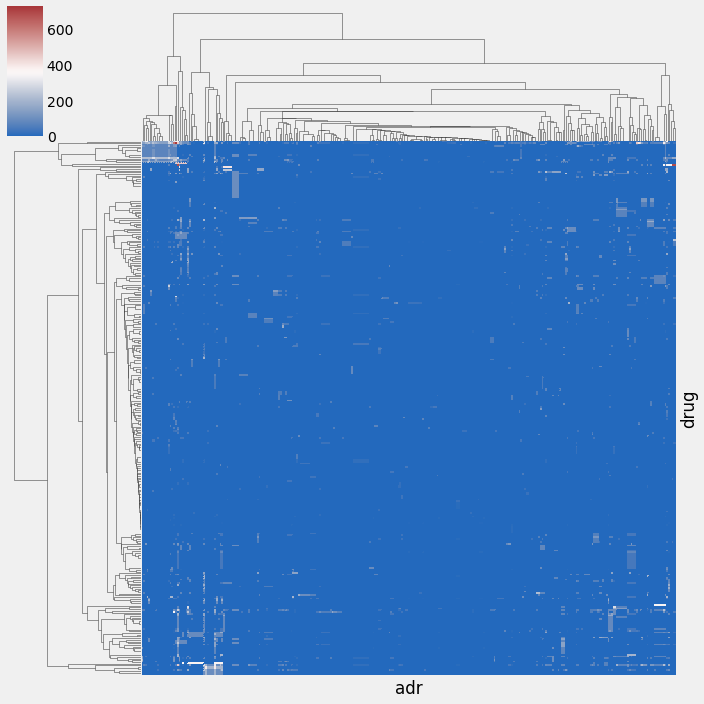

In [51]:
import seaborn as sns
 
# drugs_adr.div(drugs_adr.sum(axis=1), axis=0)
# standard_scale=1, 
g = sns.clustermap(drugs_adr, cbar=True, method='ward', cmap="vlag", xticklabels=False, yticklabels=False)

There are about 300x300 drugs by ADR. We can zoom in to explore parts of the clustered heatmap.
For instance there is a clusterin the upper left corner with patterns that look quite repetitive.
Below the subset is shown. This pattern could be caused by duplicates in the database or other artifacts.

In [52]:
# retrieve top left quadrant:
drugs_adr.iloc[
    g.dendrogram_row.reordered_ind[0:13],
    g.dendrogram_col.reordered_ind[5:15]]

adr,Cystitis,Epistaxis,Sinus disorder,Urinary tract infection,Back pain,Toxicity to various agents,Product availability issue,Muscle disorder,Bladder disorder,Glaucoma
drug,,,,,,,,,,
AMLODIPINE BESYLATE,146,186,186,146,146,146,146,146,146,146
LISINOPRIL,146,234,186,195,169,146,146,146,146,146
ATENOLOL,73,113,113,73,73,73,73,73,73,73
BIMATOPROST,73,113,113,73,73,73,73,73,73,73
EPINEPHRINE BITARTRATE\LIDOCAINE HYDROCHLORIDE,73,73,73,73,73,73,73,73,73,73
SULFAMETHOXAZOLE\TRIMETHOPRIM,73,113,113,73,73,73,73,73,73,73
CHLORZOXAZONE,73,113,113,73,73,73,73,73,73,73
TRAVOPROST,73,113,113,73,73,73,73,73,73,73
LATANOPROST,73,113,113,73,73,73,73,73,73,73


The other subset, just below this quadrant, shows some strong relations between drugs and ADR. Let us examine them further in a tabular format.

In [53]:
drugs_adr.iloc[
    g.dendrogram_row.reordered_ind[9:15],
    g.dendrogram_col.reordered_ind[19:30]]

adr,Rash,Headache,Feeling abnormal,Fatigue,Asthenia,Cognitive disorder,Disturbance in attention,Dizziness,Somnolence,Overdose,Weight decreased
drug,,,,,,,,,,,
METOPROLOL SUCCINATE,73,0,0,0,0,0,0,0,0,57,0
ESOMEPRAZOLE MAGNESIUM,219,298,0,0,0,0,0,99,0,0,0
HYDROCHLOROTHIAZIDE,256,92,92,160,92,92,92,42,0,0,0
OMEPRAZOLE MAGNESIUM,146,77,0,79,0,0,0,72,0,0,0
LENALIDOMIDE,460,460,460,460,460,460,460,0,0,0,0
NEBIVOLOL HYDROCHLORIDE,0,688,76,0,0,0,0,0,0,0,0


Here, Lenalidomide and Lisinopril have similar profiles on the clustergram. They all seem to be related to disturbance of attention, asthenia, fatigue and feeling abnormal, as well as rash and headache.

Lenalidomide is a chemotherapy drug that can treat myelodysplastic syndrome (MDS), multiple myeloma, and mantle cell lymphoma (MCL) (according to First Databank).

Whereas Lisinopril is an ACE inhibitor that can treat high blood pressure and heart failure. It can also reduce the risk of death after a heart attack (according to First Databank).

Without using any statistical approach is difficult to assess whether in any specific condition there is a disproportionality in association between a drug and an adverse reaction.

A quick literature search revealed a paper comparing several quantitative tests:

    "A comparison of measures of disproportionality for signal detection in spontaneous reporting systems for adverse drug reactions" van Puijenbroek et al. Pharmacoepidemiology and Drug Safety, 2002; 11: 3–10

Below I implemented two tests:

- Test: Reporting Odds Ratio (ROR) 􏰀- 1.96 SE > 1 
- Test: proportional reporting ratio (PRR) 􏰀- 1.96 SE > 1 

Reporting Odds ratio is a measure of disproportionality in case/non-case approach.    

In PRR Adverse event is reported for patients taking specific drug compared to the frequency at which the same adverse event is reported for patients taking some other drug.

    “A PRR greater than 1 suggests that the adverse event is more commonly reported for individuals taking the drug of interest, relative to the comparison drugs. This could indicate that the adverse event is caused by the drug of interest and therefore a "side effect", although a PRR exceeding 1 could also reflect sampling variation in the data, reporting errors, biased reporting, multiple reports of the same case or the same patient, or a number of other causes.”


The calculations are based on a contingency table, which in turn is using the drug-ADR matrix.

From the contingency table an odds ratio or reporting ratio statistic is calculated. We further assess the bottom bracket of the 95% confidence interval, calculated using standard error. If the value is above 1 then we have detected disproportionality.

I have not evaluated statistical significance of ROR or PRR, however it can be avaluated using Fisher exact test, for instance, as suggested in the paper cited above.

In case of multiple testing, when testing each represented drug-ADR combination, a multiple testing correction like Bonferroni or Benjamini-Hochberg has to be applied to correct the p-values.

I also created simple unit tests to check that ROR and PRR functions work as expected. However, the tests are not comprehensive.

In [54]:
import numpy as np

def make_contingency_table(drugs_adr, drug, adr):
    """ 
        Contingency table:

        a = Reports with the suspected drug and suspected ADR
        b = Reports with the suspected drug and without the suspected ADR

        c = All other reports with the suspected ADR
        d = All other reports without the suspected ADR    
    """
    a = drugs_adr.loc[drug, adr]
    b = drugs_adr.loc[drug, :].sum() - a
    c = drugs_adr.loc[:, adr].sum() - a
    d = drugs_adr.sum().sum() - a - b - c
    return a, b, c, d


def ROR_test(contingency_table):
    """
    Reporting odds ratio test
    
    Stricker BHCh, Tijssen JGP. Serum sickness-like reactions to cefaclor. J Clin Epidemiol 1992; 45: 1177–1184.
    """
    a, b, c, d = contingency_table
    # none of the values is allowed to be zero
    assert a * b * c * d > 0
    ror = (a*d) / (b*c)
    se_lnror = np.sqrt(1/a + 1/b + 1/c + 1/d)
    # 95% CI
    return np.round(
        np.exp(np.log(ror) - 1.96*se_lnror), 4)



def PRR_test(contingency_table):
    """
    Proportional ADR reporting ratio (PRR)
    
    Greenland S, Rothman KJ. Introduction to categorical statistics. Greenland S, Rothman KJ (eds). In Modern Epidemiology (2nd
edn), Lippincott-Raven: Philadelphia, 2001; 231–252.
    """
    a, b, c, d = contingency_table
    # a or c are not allowed to be zero
    assert a * c > 0
    prr = (a / (a + b))  / (c / (c + d)) 
    se_lnprr = np.sqrt(1/a - 1/(a+b) + 1/c + 1/(c+d))
    return np.round(
        np.exp(np.log(prr) - 1.96*se_lnprr), 4)


def unit_tests():
    """ This is just an example of unit tests, checking for output sanity """
    assert ROR_test((1,1,1,1)) < 1.0
    assert PRR_test((1,1,1,1)) < 1.0
    
    assert ROR_test((5,1,50,100)) > 1.0
    assert PRR_test((5,1,50,100)) > 1.0

    print("Tests passed")


unit_tests()

Tests passed


## Drug-drug similarities based on ADR

It has been previously suggested in several studies that drug-drug similarities in terms of adverse reactions may indicate similar mode of action or common targets for both drugs.

Additionally, we may be interested in finding whether any adverse reactions are caused by particular drug-drug interactions.

We will be using dimensionality reduction followed by clustering to reveal if there are distinct groups of similar drugs used in conjunction with Hypertensia treatment.

Drugs are compared based on their ADR profiles.

In this example we will be using UMAP (Uniform Manifold Approximation and Projection) - a widely used technique for nonlinear dimensionality reduction (McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018)

In [55]:

!pip install umap-learn
import umap

# Fix the random state for reproducibility
embedding = umap.UMAP(random_state=42).fit_transform(drugs_adr)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Clustering is done in the transformed 2D representation with DBSCAN density-based nonparametric algorithm that does not require an a priori knowlege of the number of clusters. It has, however parameters, such as *eps*  distance and the minimal number of points *m*. It looks for at least *m* points within the *eps* neighbourhood to form a cluster.

In [56]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=2).fit(embedding)
labels = clustering.labels_

Cluster labels are then used to assign colors to the points.

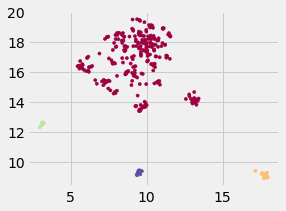

In [57]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, c=labels, cmap='Spectral')

Below I extract the list drugs from each of the two smallest clusters.

In [58]:
drugs_adr.index[labels == 2]

Index(['ACYCLOVIR', 'BUPROPION', 'CALCITRIOL', 'CALCIUM CITRATE', 'GABAPENTIN',
       'INDAPAMIDE', 'MAGNESIUM OXIDE', 'METHADONE HYDROCHLORIDE',
       'PREDNISONE', 'SERTRALINE HYDROCHLORIDE', 'SIROLIMUS'],
      dtype='object', name='drug')

In [59]:
drugs_adr.index[labels == 1]

Index(['ACETAMINOPHEN', 'ALLOPURINOL', 'ATORVASTATIN', 'CEFUROXIME',
       'DIPHENHYDRAMINE', 'DOCUSATE', 'DORZOLAMIDE', 'FERROUS SULFATE',
       'FLUTICASONE\FLUTICASONE PROPIONATE', 'LACTULOSE', 'LIDOCAINE',
       'LORATADINE', 'MONTELUKAST SODIUM', 'MUPIROCIN', 'TAMSULOSIN',
       'TRIAMCINOLONE', 'ZINC OXIDE'],
      dtype='object', name='drug')

In order to understand why these drugs ended up in same clusters we may apply enrichment analysis using drug class labels according to:
    - Mode of action,
    - Physiologic effect,
    - Chemical Structure,
    - Established pharmacologic

This follow-up analysis is out of scope.

## Conclusions

OpenFDA is a convenient open access data source for pharmacovigilance data science projects. 

There are numerous limitations that need to be considered carefully while analyzing the data. Preliminary analysis also revealed presence of various reporting biases.

The major limitation of the data is that no causal relationship between drugs and adverse reactions could be established based on the data alone. However, as illustrated in this report, there are approaches that would allow us to infer suspect drug-ADR relationships and assess their strength and significance.

Drug-drug interactions may be causing adverse reactions, and are preventable if such drug interactions are known. Similar to what has been illustrated with drug-drug similarity analysis, OpenFDA data could potentially be used to identify novel drug interactions.

OpenFDA ElasticSearch API does not allow complex queries or retrieving larger collections of reports at a time, besides the API is rate-limited. This limitation is technical and could be overcome by transferring the JSON-dump data to Storage, for instance, and then loading it into Spark. Moreover, at current dataset size it can easily be handled by a single machine, not requiring distributed computing and/or storage.